In [108]:
from __future__ import absolute_import
from sfepy.mechanics.matcoefs import stiffness_from_youngpoisson
from sfepy.discrete.fem.utils import refine_mesh
from sfepy import data_dir
from sfepy.discrete import Problem
import matplotlib.pyplot as plt

# Fix the mesh file name if you run this file outside the SfePy directory.
filename_mesh = data_dir + '/meshes/2d/its2D.mesh'

refinement_level = 0
filename_mesh = refine_mesh(filename_mesh, refinement_level)

output_dir = 'Users\yesda\Desktop'  # Set this to a valid directory you have write access to

young = 2000.0  # Young's modulus [MPa]
poisson = 0.4  # Poisson's ratio

options = {
    'output_dir': output_dir,
}

regions = {
    'Omega': 'all',
    'Left': ('vertices in (x < 0.001)', 'facet'),
    'Bottom': ('vertices in (y < 0.001)', 'facet'),
    'Top': ('vertex 2', 'vertex'),
}

materials = {
    'Asphalt': ({'D': stiffness_from_youngpoisson(2, young, poisson)},),
    'Load': ({'.val': [0.0, -1000.0]},),
}

fields = {
    'displacement': ('real', 'vector', 'Omega', 1),
}

equations = {
    'balance_of_forces':
    """dw_lin_elastic.2.Omega(Asphalt.D, v, u)
       = dw_point_load.0.Top(Load.val, v)""",
}

variables = {
    'u': ('unknown field', 'displacement', 0),
    'v': ('test field', 'displacement', 'u'),
}

ebcs = {
    'XSym': ('Bottom', {'u.1': 0.0}),
    'YSym': ('Left', {'u.0': 0.0}),
}

solvers = {
    'ls': ('ls.scipy_direct', {}),
    'newton': ('nls.newton', {
        'i_max': 1,
        'eps_a': 1e-6,
    }),
}


<>:14: SyntaxWarning: invalid escape sequence '\y'
<>:14: SyntaxWarning: invalid escape sequence '\y'
C:\Users\yesda\AppData\Local\Temp\ipykernel_28348\2531520207.py:14: SyntaxWarning: invalid escape sequence '\y'
  output_dir = 'Users\yesda\Desktop'  # Set this to a valid directory you have write access to


In [90]:
import numpy as np
from sfepy import data_dir
from sfepy.discrete.fem import Mesh, FEDomain, Field
from sfepy.terms import Term
from sfepy.discrete import Problem
from sfepy.discrete.conditions import EssentialBC
from sfepy.discrete.variables import Variables
from sfepy.mechanics.matcoefs import stiffness_from_youngpoisson
from sfepy.solvers.ls import ScipyDirect
from sfepy.solvers.nls import Newton
import matplotlib.pyplot as plt
from sfepy.discrete import Integral

# Create a simple 2D mesh
mesh_file = data_dir + '/meshes/2d/square_unit_tri.mesh'
mesh = Mesh.from_file(mesh_file)

# Define the finite element domain
domain = FEDomain('domain', mesh)
print(domain.mesh.get_bounding_box())

# Define regions
regions = {
    'all': domain.create_region('all', 'all'),
    'left': domain.create_region('left', 'vertices in x < -0.39'),
    'right': domain.create_region('right', 'vertices in x > 0.39'),
    'bottom': domain.create_region('bottom', 'vertices in y < -0.39'),
    'top': domain.create_region('top', 'vertices in y > 0.39'),
    'center': domain.create_region('center',  'vertices in x > -0.01'),
}

# Define a field for displacements
field = Field.from_args('displacement', np.float64, 'vector', domain.regions['all'], approx_order=1)


# Define material properties (Plane Stress)
young_modulus = 210e9  # Young's modulus in Pa
poisson_ratio = 0.3    # Poisson's ratio

D = stiffness_from_youngpoisson(young=young_modulus, poisson=poisson_ratio, plane='stress',dim=2)



# Define boundary conditions
fixed_bc = EssentialBC('fixed', domain.regions['left'], {'u.all': 0.0})  # Fixed edges
force_bc = EssentialBC('force', domain.regions['center'], {'u.1': -0.01})  # Force applied at center

# Define the integral
integral = Integral('i', order=2)  # Quadrature order 2
# Define the term for linear elasticity
term = Term.new('dw_lin_elastic(solid.D, v, u)',integral=integral, region=domain.regions['all'], material={'solid.D': D}, v=field, u=field)

# Define the problem
# Define equations
equations = {
    'balance_of_forces': 'dw_lin_elastic(solid.D, v, u) = 0',
}
variables = Variables.from_conf(
    {
        'u': ('unknown field', 'displacement', 0),
        'v': ('test field', 'displacement', 1),
    },
    [field]
)

# Initialize the problem explicitly
pb = Problem(
    name='2D Plate with Center Load',
    domain=domain,
    equations=equations
)
# Solve the problem
state = pb.solve()

# Extract the displacement for visualization
coors = pb.domain.mesh.coors
displacements = state.get_state_parts()['u']

# Visualization
plt.figure(figsize=(6, 6))
plt.triplot(coors[:, 0], coors[:, 1], pb.domain.mesh.get_conn('2_3'), color='gray', alpha=0.5)
plt.quiver(coors[:, 0], coors[:, 1], displacements[0::2], displacements[1::2], angles='xy', scale_units='xy', scale=0.1, color='blue')
plt.title('Displacement Field (Magnified)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.axis('equal')
plt.show()


sfepy:   reading mesh (C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sfepy/meshes/2d/square_unit_tri.mesh)...
sfepy:     number of vertices: 134
sfepy:     number of cells:
sfepy:       2_3: 226
sfepy:   ...done in 0.00 s
[[-0.5 -0.5]
 [ 0.5  0.5]]


AttributeError: 'tuple' object has no attribute 'kind'

In [10]:
from __future__ import absolute_import
from sfepy.examples.linear_elasticity.its2D_1 import *

from sfepy.mechanics.matcoefs import stiffness_from_youngpoisson

def stress_strain(out, pb, state, extend=False):
    """
    Calculate and output strain and stress for given displacements.
    """
    from sfepy.base.base import Struct

    ev = pb.evaluate
    strain = ev('ev_cauchy_strain.2.Omega(u)', mode='el_avg')
    stress = ev('ev_cauchy_stress.2.Omega(Asphalt.D, u)', mode='el_avg',
                copy_materials=False)

    out['cauchy_strain'] = Struct(name='output_data', mode='cell',
                                  data=strain, dofs=None)
    out['cauchy_stress'] = Struct(name='output_data', mode='cell',
                                  data=stress, dofs=None)

    return out

asphalt = materials['Asphalt'][0]
asphalt.update({'D' : stiffness_from_youngpoisson(2, young, poisson)})
options.update({'post_process_hook' : 'stress_strain',})

In [11]:
sfepy-run its2D_2.py
sfepy-view its2D.vtk -2 --max-plots 2

SyntaxError: invalid syntax (3606979723.py, line 1)

In [8]:
import numpy as nm

import sys
sys.path.append('.')

from sfepy.base.base import output
from sfepy.mechanics.matcoefs import stiffness_from_lame
from sfepy.homogenization.utils import interp_conv_mat
from sfepy import data_dir

def linear_tension(ts, coors, mode=None, verbose=True, **kwargs):
    if mode == 'qp':
        val = 1.0 * ((ts.step > 0) and (ts.nt <= 0.5))

        if verbose:
            output('load:', val)

        val = nm.tile(val, (coors.shape[0], 1, 1))

        return {'val' : val}

def get_exp_fading_kernel(coef0, decay, times):
    val = coef0[None, ...] * nm.exp(-decay * times[:, None, None])
    return val

def get_th_pars(ts, coors, mode=None, times=None, kernel=None, **kwargs):
    out = {}

    if mode == 'special':
        out['H'] = interp_conv_mat(kernel, ts, times)

    elif mode == 'qp':
        out['H0'] = kernel[0][None, ...]
        out['Hd'] = nm.array([[[kernel[1, 0, 0] / kernel[0, 0, 0]]]])

    return out

def post_process(out, pb, state, extend=False):
    """
    Calculate and output strain and stress for given displacements.
    """
    from sfepy.base.base import Struct

    ev = pb.evaluate
    strain = ev('ev_cauchy_strain.2.Omega(u)', mode='el_avg')
    out['cauchy_strain'] = Struct(name='output_data', mode='cell',
                                  data=strain, dofs=None)

    estress = ev('ev_cauchy_stress.2.Omega(solid.D, u)', mode='el_avg')
    out['cauchy_stress'] = Struct(name='output_data', mode='cell',
                                  data=estress, dofs=None)

    ts = pb.get_timestepper()
    if pb.conf.mode == 'th':
        vstress = ev('ev_cauchy_stress_th.2.Omega(ts, th.H, du/dt)',
                     ts=ts, mode='el_avg')
        out['viscous_stress'] = Struct(name='output_data', mode='cell',
                                       data=vstress, dofs=None)

    else:
        # The eth terms require 'preserve_caches=True' in order to have correct
        # fading memory history.
        vstress = ev('ev_cauchy_stress_eth.2.Omega(ts, th.H0, th.Hd, du/dt)',
                     ts=ts, mode='el_avg', preserve_caches=True)
        out['viscous_stress'] = Struct(name='output_data', mode='cell',
                                       data=vstress, dofs=None)

    out['total_stress'] = Struct(name='output_data', mode='cell',
                                 data=estress + vstress, dofs=None)

    return out

def define(verbose=False):
    filename_mesh = data_dir + '/meshes/3d/block.mesh'

    ## Configure below. ##

    # Time stepping times.
    t0 = 0.0
    t1 = 20.0
    n_step = 21

    # Fading memory times.
    f_t0 = 0.0
    f_t1 = 5.0
    f_n_step = 6

    decay = 0.8
    mode = 'eth'

    ## Configure above. ##

    times = nm.linspace(f_t0, f_t1, f_n_step)
    kernel = get_exp_fading_kernel(stiffness_from_lame(3, lam=1.0, mu=1.0),
                                   decay, times)

    dt = (t1 - t0) / (n_step - 1)
    fading_memory_length = min(int((f_t1 - f_t0) / dt) + 1, n_step)
    output('fading memory length:', fading_memory_length, verbose=verbose)

    options = {
        'ts' : 'ts',
        'nls' : 'newton',
        'ls' : 'ls',

        'output_format'     : 'h5',
        'post_process_hook' : 'post_process',
    }

    functions = {
        'linear_tension' : (linear_tension,),
        'get_pars' : (lambda ts, coors, mode=None, **kwargs:
                      get_th_pars(ts, coors, mode, times=times, kernel=kernel,
                                  **kwargs),),
    }

    fields = {
        'displacement': ('real', 3, 'Omega', 1),
    }

    materials = {
        'solid' : ({
            'D' : stiffness_from_lame(3, lam=5.769, mu=3.846),
        },),
        'th' : 'get_pars',
        'load' : 'linear_tension',
    }

    variables = {
        'u' : ('unknown field', 'displacement', 0, fading_memory_length),
        'v' : ('test field', 'displacement', 'u'),
    }

    regions = {
        'Omega' : 'all',
        'Left' : ('vertices in (x < -4.99)', 'facet'),
        'Right' : ('vertices in (x > 4.99)', 'facet'),
    }

    ebcs = {
        'fixb' : ('Left', {'u.all' : 0.0}),
        'fixt' : ('Right', {'u.[1,2]' : 0.0}),
    }

    if mode == 'th':
        # General form with tabulated kernel.
        equations = {
            'elasticity' :
            """dw_lin_elastic.2.Omega( solid.D, v, u )
             + dw_lin_elastic_th.2.Omega( ts, th.H, v, du/dt )
             = - dw_surface_ltr.2.Right( load.val, v )""",
        }

    else:
        # Fast form that is exact for exponential kernels.
        equations = {
            'elasticity' :
            """dw_lin_elastic.2.Omega( solid.D, v, u )
             + dw_lin_elastic_eth.2.Omega( ts, th.H0, th.Hd, v, du/dt )
             = - dw_surface_ltr.2.Right( load.val, v )""",
        }

    solvers = {
        'ls' : ('ls.scipy_direct', {}),
        'newton' : ('nls.newton', {
            'i_max' : 1,
            'eps_a' : 1e-10,
        }),
        'ts' : ('ts.simple', {
            't0' : t0,
            't1' : t1,
            'dt' : None,
            'n_step' : n_step,
            'quasistatic' : True,
            'verbose' : 1,
        }),
    }

    return locals()

def main():
    """
    Plot the load, displacement, strain and stresses w.r.t. time.
    """
    from argparse import ArgumentParser, RawDescriptionHelpFormatter
    import matplotlib.pyplot as plt

    from sfepy.base.base import Struct
    import sfepy.postprocess.time_history as th

    msgs = {
        'node': 'plot displacements in given node [default: %(default)s]',
        'element': 'plot tensors in given element [default: %(default)s]',
    }

    parser = ArgumentParser(description=__doc__,
                            formatter_class=RawDescriptionHelpFormatter)
    parser.add_argument(metavar='OUTPUT_FILE', dest='output_file',
                        help='output file in HDF5 format')
    parser.add_argument('-n', '--node', type=int, metavar='ii',
                        action='store', dest='node',
                        default=512, help=msgs['node'])
    parser.add_argument('-e', '--element', type=int, metavar='ii',
                        action='store', dest='element',
                        default=299, help=msgs['element'])
    options = parser.parse_args()

    filename = options.output_file

    tensor_names = ['cauchy_strain',
                    'cauchy_stress', 'viscous_stress', 'total_stress']
    extract = ('u n %d, ' % options.node) \
              + ', '.join('%s e %d' % (name, options.element)
                          for name in tensor_names)
    ths, ts = th.extract_time_history(filename, extract)

    load = [linear_tension(ts, nm.array([0]),
                           mode='qp', verbose=False)['val'].squeeze()
            for ii in ts]
    load = nm.array(load)

    conf = Struct(**define(verbose=True))
    normalized_kernel = conf.kernel[:, 0, 0] / conf.kernel[0, 0, 0]

    plt.figure(1, figsize=(8, 10))
    plt.subplots_adjust(hspace=0.3,
                        top=0.95, bottom=0.05, left=0.07, right=0.95)

    plt.subplot(311)
    plt.plot(conf.times, normalized_kernel, lw=3)
    plt.title('fading memory decay')
    plt.xlabel('time')

    plt.subplot(312)
    plt.plot(ts.times, load, lw=3)
    plt.title('load')
    plt.xlabel('time')

    displacements = ths['u'][options.node]

    plt.subplot(313)
    plt.plot(ts.times, displacements, lw=3)
    plt.title('displacement components, node %d' % options.node)
    plt.xlabel('time')
    plt.tight_layout()

    plt.figure(2, figsize=(8, 10))
    plt.subplots_adjust(hspace=0.35,
                        top=0.95, bottom=0.05, left=0.07, right=0.95)

    for ii, tensor_name in enumerate(tensor_names):
        tensor = ths[tensor_name][options.element]

        plt.subplot(411 + ii)
        plt.plot(ts.times, tensor, lw=3)
        plt.title('%s components, element %d' % (tensor_name, options.element))
        plt.xlabel('time')

    plt.tight_layout()

    plt.show()

if __name__ == '__main__':
    main()

usage: ipykernel_launcher.py [-h] [-n ii] [-e ii] OUTPUT_FILE
ipykernel_launcher.py: error: the following arguments are required: OUTPUT_FILE


SystemExit: 2

In [109]:
from __future__ import absolute_import
from sfepy.mechanics.matcoefs import stiffness_from_youngpoisson
from sfepy.discrete.fem.utils import refine_mesh
from sfepy import data_dir
import matplotlib.pyplot as plt
# Fix the mesh file name if you run this file outside the SfePy directory.
filename_mesh = data_dir + '/meshes/2d/its2D.mesh'

refinement_level = 0
filename_mesh = refine_mesh(filename_mesh, refinement_level)

output_dir = '.' # set this to a valid directory you have write access to

young = 2000.0 # Young's modulus [MPa]
poisson = 0.4  # Poisson's ratio

options = {
    'output_dir' : output_dir,
}

regions = {
    'Omega' : 'all',
    'Left' : ('vertices in (x < 0.001)', 'facet'),
    'Bottom' : ('vertices in (y < 0.001)', 'facet'),
    'Top' : ('vertex 2', 'vertex'),
}

materials = {
    'Asphalt' : ({'D': stiffness_from_youngpoisson(2, young, poisson)},),
    'Load' : ({'.val' : [0.0, -1000.0]},),
}

fields = {
    'displacement': ('real', 'vector', 'Omega', 1),
}

equations = {
   'balance_of_forces' :
   """dw_lin_elastic.2.Omega(Asphalt.D, v, u)
      = dw_point_load.0.Top(Load.val, v)""",
}

variables = {
    'u' : ('unknown field', 'displacement', 0),
    'v' : ('test field', 'displacement', 'u'),
}

ebcs = {
    'XSym' : ('Bottom', {'u.1' : 0.0}),
    'YSym' : ('Left', {'u.0' : 0.0}),
}

solvers = {
    'ls' : ('ls.scipy_direct', {}),
    'newton' : ('nls.newton', {
        'i_max' : 1,
        'eps_a' : 1e-6,
    }),
}

from sfepy.discrete import Problem

# Initialize the problem
pb = Problem(
    name='2D Plate with Center Load',
    equations=equations,
    regions=regions,
    materials=materials,
    fields=fields,
    variables=variables,
    ebcs=ebcs,
    solvers=solvers,
    options=options,
)

# Solve the problem
state = pb.solve()

# Save the solution to a VTK file
pb.save_state('solution.vtk', state)

print("Solution saved to 'solution.vtk'")



TypeError: Problem.__init__() got an unexpected keyword argument 'regions'

In [5]:
#FEM Example 1
import numpy as np
from sfepy import data_dir
from sfepy.discrete.fem import Mesh, FEDomain, Field
from sfepy.terms import Term
from sfepy.discrete import Problem
from sfepy.discrete.conditions import EssentialBC
from sfepy.mechanics.matcoefs import stiffness_from_youngpoisson
from sfepy.solvers.ls import ScipyDirect
from sfepy.solvers.nls import Newton

# Create a simple 2D mesh
mesh_file = data_dir + '/meshes/2d/square_unit_tri.mesh'
mesh = Mesh.from_file(mesh_file)

# Define the finite element domain
domain = FEDomain('domain', mesh)

# Define a field for displacements
#field = Field.from_args('displacement', np.float64, 'vector', domain, approx_order=1)

# Define material properties (Plane Stress)
young_modulus = 210e9  # Young's modulus in Pa
poisson_ratio = 0.3    # Poisson's ratio
D = stiffness_from_youngpoisson(young_modulus, poisson_ratio, plane='stress')

# Define regions
min_x, max_x = domain.get_mesh_bounding_box()[:, 0]
min_y, max_y = domain.get_mesh_bounding_box()[:, 1]

regions = {
    'all': 'all',
    'edges': 'vertices of surface',
    'center': 'vertex in x == 0.5 and y == 0.5',
}

# Define boundary conditions
fixed_bc = EssentialBC('fixed', domain.regions['edges'], {'u.all': 0.0})

# Define a center force
def point_load(ts, coor, region=None):
    force = np.zeros_like(coor)
    force[:, 1] = -1e6  # Force in the Y direction
    return force

force_bc = LinearBoundaryCondition('load', domain.regions['center'], {'traction': point_load})

# Define the term for linear elasticity
term = Term.new('dw_lin_elastic(solid.D, v, u)', 'all', domain.regions['all'], material={'solid.D': D}, v=field, u=field)

# Define the problem
equations = {
    'balance_of_forces': term,
}
pb = Problem('2D Plate with Center Load', equations=equations, regions=domain.regions, materials={'solid': {'D': D}}, fields=[field])

# Add boundary conditions
pb.time_update(ebcs={'fixed': fixed_bc}, lcbcs={'load': force_bc})

# Solvers
pb.set_solver('ls', ScipyDirect({}))
pb.set_solver('nls', Newton({'i_max': 10, 'eps_r': 1e-9}))

# Solve the problem
state = pb.solve()

# Save results
pb.save_state('plate_center_force.vtk', state)

print("Simulation complete! Results saved to 'plate_center_force.vtk'")


sfepy: reading mesh (C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sfepy/meshes/2d/square_unit_tri.mesh)...
sfepy:   number of vertices: 134
sfepy:   number of cells:
sfepy:     2_3: 226
sfepy: ...done in 0.00 s


TypeError: stiffness_from_youngpoisson() missing 1 required positional argument: 'poisson'

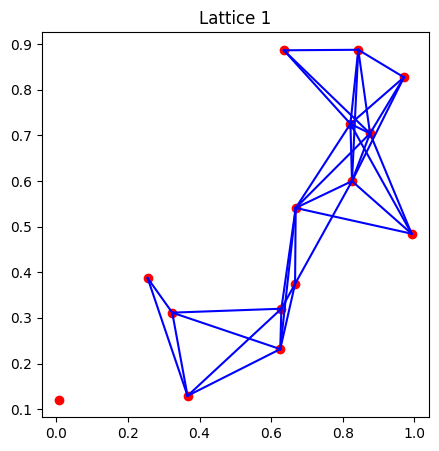

ValueError: zero-dimensional arrays cannot be concatenated

In [ ]:
#Disorder Example 1

import numpy as np
import matplotlib.pyplot as plt
from sfepy import data_dir
from sfepy.mechanics.matcoefs import stiffness_from_youngpoisson
from sfepy.discrete.fem import Mesh, FEDomain, Field
from sfepy.terms import Term
from sfepy.discrete import Problem
from sfepy.discrete.conditions import EssentialBC
from sfepy.discrete.equations import Equation

from sfepy.solvers.ls import ScipyDirect
from sfepy.solvers.nls import Newton


def create_disordered_lattice(size=1.0, num_points=10):
    """Generate a random 2D disordered lattice."""
    points = np.random.rand(num_points, 2) * size
    edges = [(i, j) for i in range(num_points) for j in range(i + 1, num_points) if np.linalg.norm(points[i] - points[j]) < size / 3]
    return points, edges


def plot_lattice(points, edges, title="Lattice"):
    """Visualize the lattice structure."""
    plt.figure(figsize=(5, 5))
    for i, j in edges:
        plt.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], 'b-')
    plt.scatter(points[:, 0], points[:, 1], color='r')
    plt.title(title)
    plt.show()


def calculate_youngs_modulus(points, edges, material_props):
    """Set up and solve for Young's modulus using SfePy."""
    # Convert lattice points to a mesh-like structure
    vertices = points
    elements = np.array([[e[0], e[1]] for e in edges])

    # Create a mesh and domain
    mesh = Mesh.from_data('lattice', vertices, None, [elements], [None], ['2_2'])
    domain = FEDomain('domain', mesh)

    # Define a field for displacements
    field = Field.from_args('displacement', np.float64, 'vector', domain, approx_order=1)

    # Material properties
    young, poisson = material_props
    lam, mu = stiffness_from_youngpoisson(young, poisson)[:2]

    # Define regions
    regions = {
        'left': 'vertices in (x < 0.01)',
        'right': 'vertices in (x > %.2f)' % (np.max(points[:, 0]) - 0.01),
        'all': 'all',
    }

    # Define boundary conditions
    bcs = {
        'left': ('left', {'u.all': 0.0}),
        'right': ('right', {'u.0': 0.001}),
    }

    # Define material and terms
    material = {'name': 'solid', 'D': stiffness_from_youngpoisson(young, poisson, plane='strain')}
    term = Term.new('dw_lin_elastic(solid.D, v, u)', 'all', domain.regions['all'], material=material, v=field, u=field)

    # Create problem
    eq = Equation({'lhs': term})
    pb = Problem('elasticity', equations={'elasticity': eq}, regions=regions, materials=[material], fields=[field])

    for bc_name, bc in bcs.items():
        pb.bc(bc_name, EssentialBC(bc_name, domain.regions[bc[0]], bc[1]))

    # Solvers
    pb.set_solver('ls', ScipyDirect({}))
    pb.set_solver('nls', Newton({'i_max': 1}))

    # Solve and calculate Young's modulus
    state = pb.solve()
    strain_energy = pb.evaluate('ev_cauchy_strain.', mode='el_eval', verbose=False)
    return strain_energy


# Parameters for the simulation
num_samples = 5
young_poisson = (210e9, 0.3)  # Steel-like material properties (Young's modulus in Pa, Poisson's ratio)

# Generate and compute for multiple lattices
for i in range(num_samples):
    points, edges = create_disordered_lattice(size=1.0, num_points=15)
    plot_lattice(points, edges, title=f"Lattice {i+1}")
    young_modulus = calculate_youngs_modulus(points, edges, young_poisson)
    print(f"Lattice {i+1} - Effective Young's Modulus: {young_modulus} Pa")
